In [1]:
import sys

sys.path.append("../")

In [2]:
from datasets import TorchvisionDataset

DATASETS = ["qmnist", "mnist", "fmnist", "kmnist", "emnist_letters", "emnist_balanced" ]
dataset_id = DATASETS[1]
dataset = TorchvisionDataset(dataset_id)

In [3]:
from fvhd import FVHD
from knn import Graph, NeighborConfig, NeighborGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_graphs(X: np.ndarray, metric: str = "euclidean", nn: int = 5) -> list[Graph]:
    config = NeighborConfig(metric=metric)
    df = pd.DataFrame(X)
    generator = NeighborGenerator(df=df, config=config)
    graphs = generator.run(nn=nn)
    return graphs

def fit_fvhd_embedding(
    X: np.ndarray,
    graphs: list[Graph],
    nn: int = 3,
    rn: int = 1,
    mutual_neighbors_epochs: int = 20,
    verbose: bool = True
) -> np.ndarray:

    fvhd = FVHD(
        n_components=2,
        nn=nn,
        rn=rn,
        c=0.1,
        eta=0.2,
        epochs=3000,
        device="mps",
        velocity_limit=True,
        autoadapt=True,
        mutual_neighbors_epochs=mutual_neighbors_epochs,
        verbose=verbose
    )

    embeddings = fvhd.fit_transform(X, graphs)
    return embeddings


def visualize_embeddings(x: np.ndarray, y: np.ndarray, dataset_name: str, marker_size: int = 5):

    plt.figure(figsize=(8, 8))
    plt.title(f"{dataset_name} 2d visualization")

    unique_labels = np.unique(y)

    for i in unique_labels:
        points = x[y == i]
        plt.scatter(
            points[:, 0], points[:, 1], label=f"{i}", marker=".", s=marker_size, alpha=0.5
        )

    plt.legend()
    plt.show()

In [4]:
X = dataset.train_images()
y = dataset.train_labels().numpy()

graphs = create_graphs(X, metric="euclidean", nn=5)

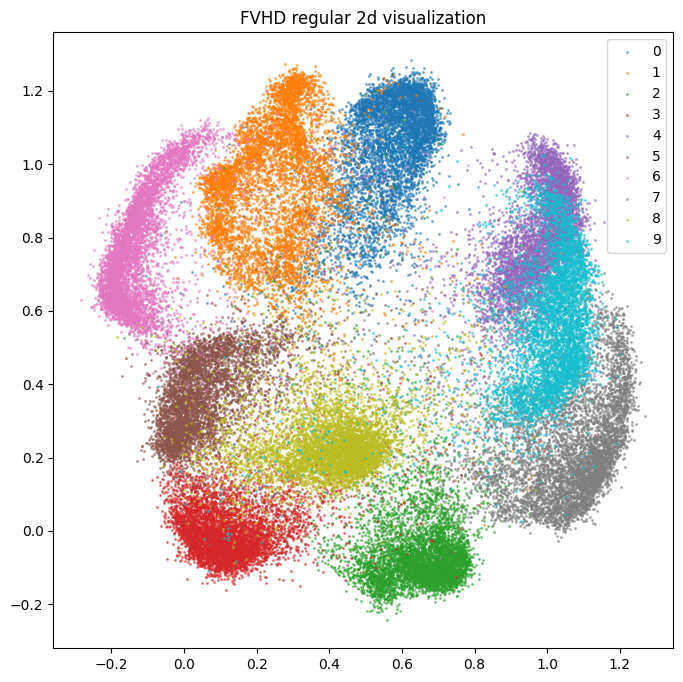

In [5]:
X_embedded = fit_fvhd_embedding(
    X, graphs, nn=5, rn=2, mutual_neighbors_epochs=None, verbose=False
)
visualize_embeddings(X_embedded, y, "FVHD regular")

In [6]:
neighbor_classes = y[graphs[0].indexes]
distances = graphs[0].distances

node_class, neighbor_classes = neighbor_classes[:, 0], neighbor_classes[:, 1:]
comparison = node_class.reshape(-1, 1) == neighbor_classes
wrong_neighbor_count = np.sum(1 - comparison, axis=1)

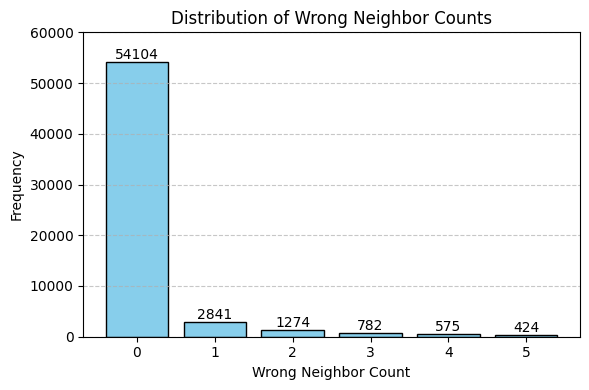

In [7]:
counts = [i for i in range(wrong_neighbor_count.max() + 1)]
bars = [(wrong_neighbor_count == i).sum().item() for i in counts]

plt.figure(figsize=(6, 4))
barplot = plt.bar(counts, bars, color='skyblue', edgecolor='black')

for i, value in enumerate(bars):
    plt.text(counts[i], value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(counts)  # Ensure integer ticks on x-axis
plt.xlabel('Wrong Neighbor Count')
plt.ylabel('Frequency')
plt.title('Distribution of Wrong Neighbor Counts')

plt.ylim(0, len(X))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [15]:
def exponential_weights(alpha: float, N: int):
    """
    Create a vector of exponentially decaying weights for a fixed window size N.
    alpha: smoothing factor (0 < alpha < 1)
    N: number of points in the average
    """
    weights = (1 - alpha) ** np.arange(N)  # Reverse so recent is most important
    return weights / weights.sum() 

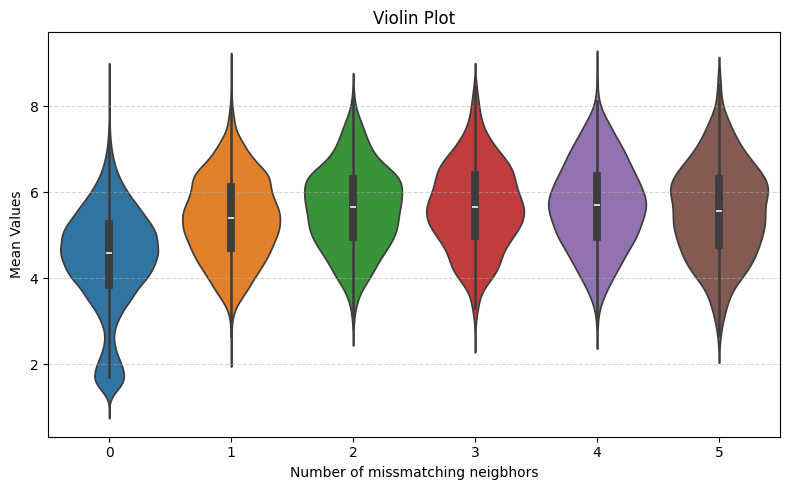

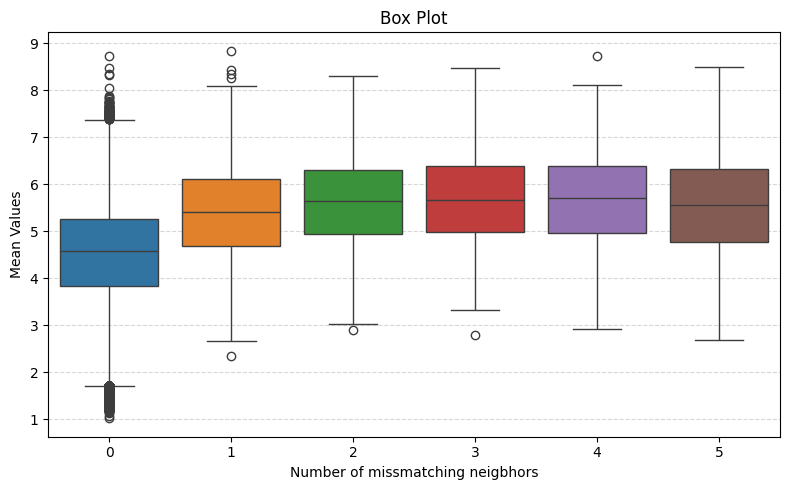

In [21]:
import seaborn as sns

n = max(wrong_neighbor_count) + 1
weights = exponential_weights(0., 5).reshape(5, 1)

data_series = []
for i in range(n):
    label_distances = distances[wrong_neighbor_count == i][:, 1:]
    data_series.append((label_distances @ weights).flatten())

labels = [f"Series {i+1}" for i in range(n)]

plt.figure(figsize=(8, 5))
sns.violinplot(data=data_series)
plt.xticks(ticks=range(n))

plt.xlabel("Number of missmatching neigbhors")
plt.title('Violin Plot')
plt.ylabel('Mean Values')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_series)
plt.xticks(ticks=range(n))

plt.xlabel("Number of missmatching neigbhors")
plt.title('Box Plot')
plt.ylabel('Mean Values')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

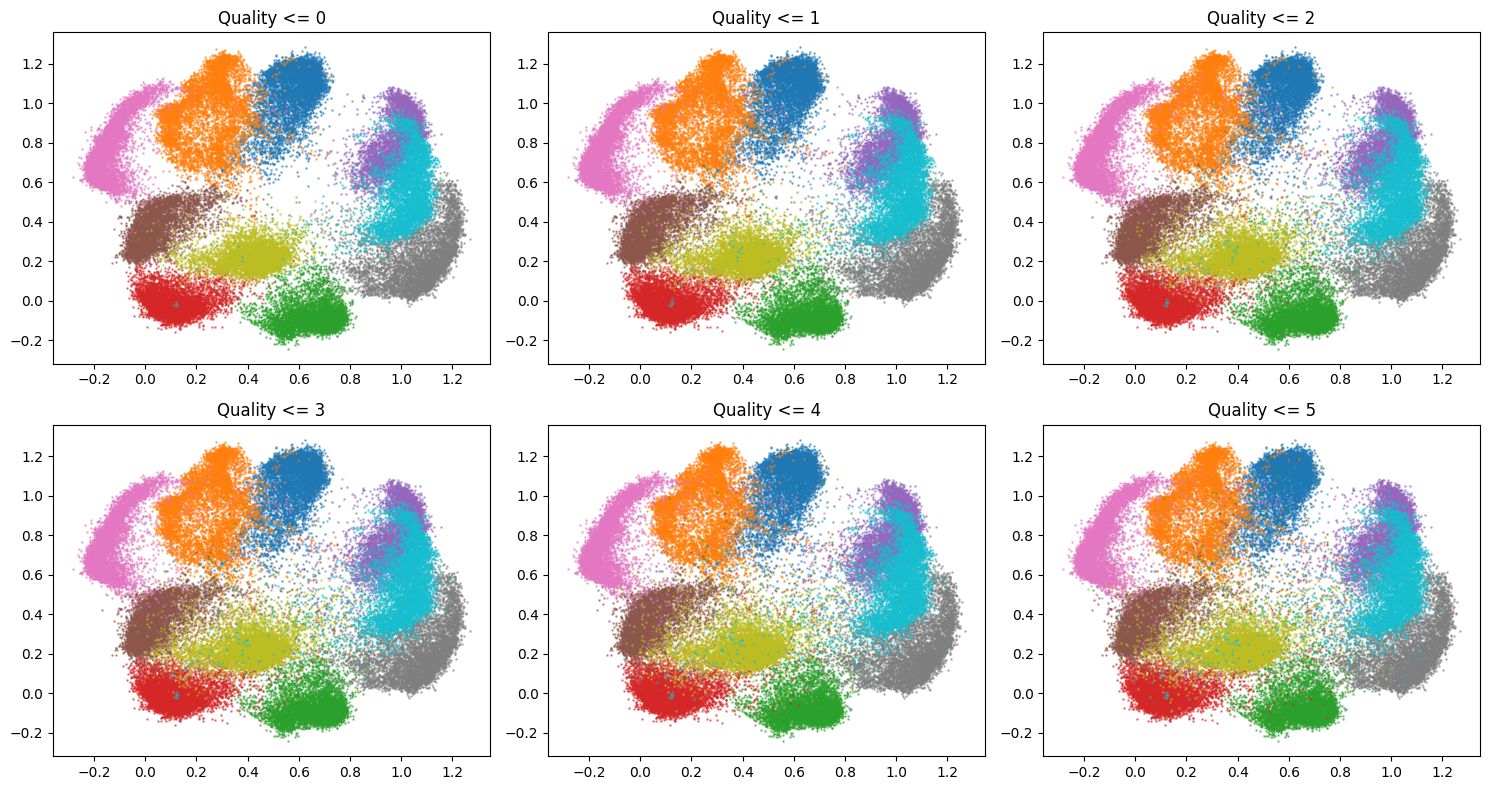

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes = axes.flatten()

for level in range(wrong_neighbor_count.max() + 1):
    cleaned_subset = np.where(np.sum(1 - comparison, axis=1) <= level)[0]

    x_cleaned, y_cleaned = X_embedded[cleaned_subset], y[cleaned_subset]

    unique_labels = np.unique(y)

    for i in unique_labels:
        points = x_cleaned[y_cleaned == i]
        axes[level].scatter(
            points[:, 0], points[:, 1], label=f"{i}", marker=".", s=3, alpha=0.5
        )

    axes[level].set_title(f"Quality <= {level}")


plt.tight_layout()
plt.show()

(60000,)
(59576,)
(59001,)
(58219,)
(56945,)
(54104,)


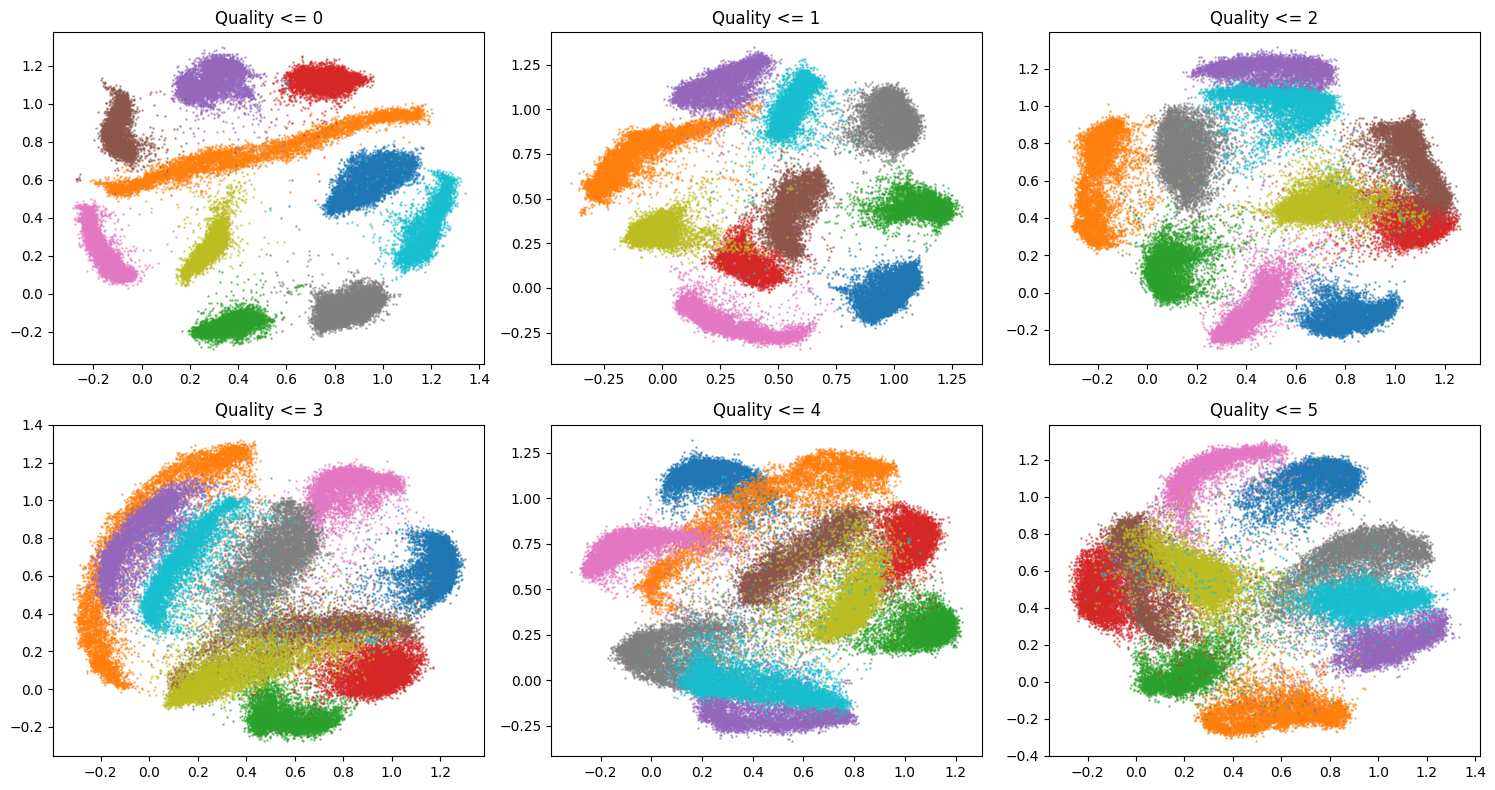

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes = axes.flatten()

for level in range(wrong_neighbor_count.max(), -1, -1):
    cleaned_subset = np.where(np.sum(1 - comparison, axis=1) <= level)[0]
    
    X_cleaned = X[cleaned_subset]
    y_cleaned = y[cleaned_subset]

    print(cleaned_subset.shape)

    graphs = create_graphs(X_cleaned, metric="euclidean", nn=5)
    X_embedded = fit_fvhd_embedding(
        X_cleaned, graphs, nn=5, rn=2, mutual_neighbors_epochs=None, verbose=False
    )

    unique_labels = np.unique(y_cleaned)

    for i in unique_labels:
        points = X_embedded[y_cleaned == i]
        axes[level].scatter(
            points[:, 0], points[:, 1], label=f"{i}", marker=".", s=3, alpha=0.5
        )

    axes[level].set_title(f"Quality <= {level}")
    # visualize_embeddings(X_embedded, y_cleaned, f"FVHD cleaned")


plt.tight_layout()
plt.show()

In [23]:
X = dataset.train_images()
y = dataset.train_labels().numpy()

graphs = create_graphs(X, metric="euclidean", nn=5)
distances = graphs[0].distances

weights = exponential_weights(0.0, 5)
# mean_distances = np.mean(distances[:, 1:], axis=1)
mean_distances = (distances[:, 1:] @ weights.reshape(5, 1)).flatten()

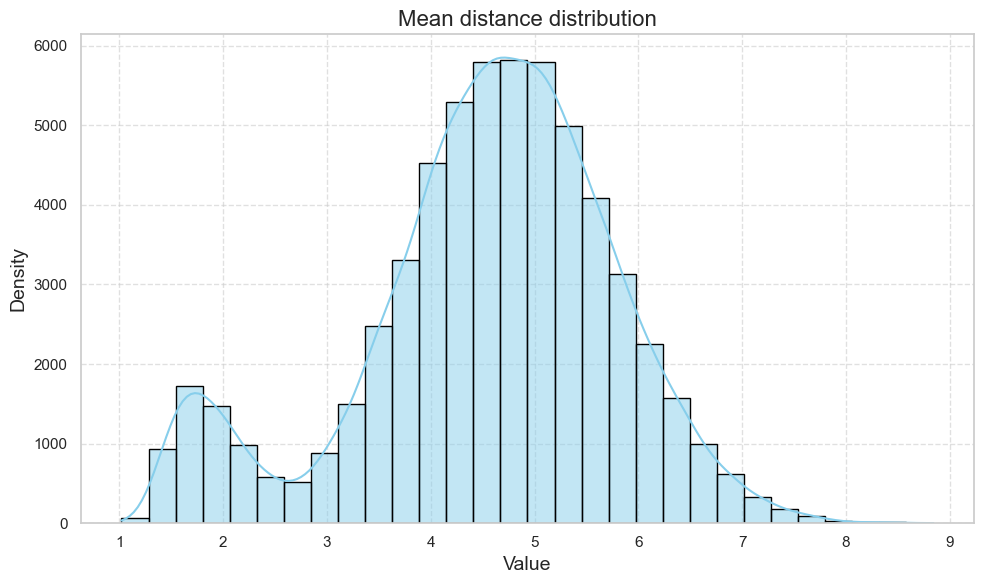

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# # Styl wykresu
# sns.set(style="whitegrid")

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
sns.histplot(mean_distances, kde=True, bins=30, color="skyblue", edgecolor="black")

# Opisy osi i tytuł
plt.title("Mean distance distribution", fontsize=16)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Siatka i estetyka
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

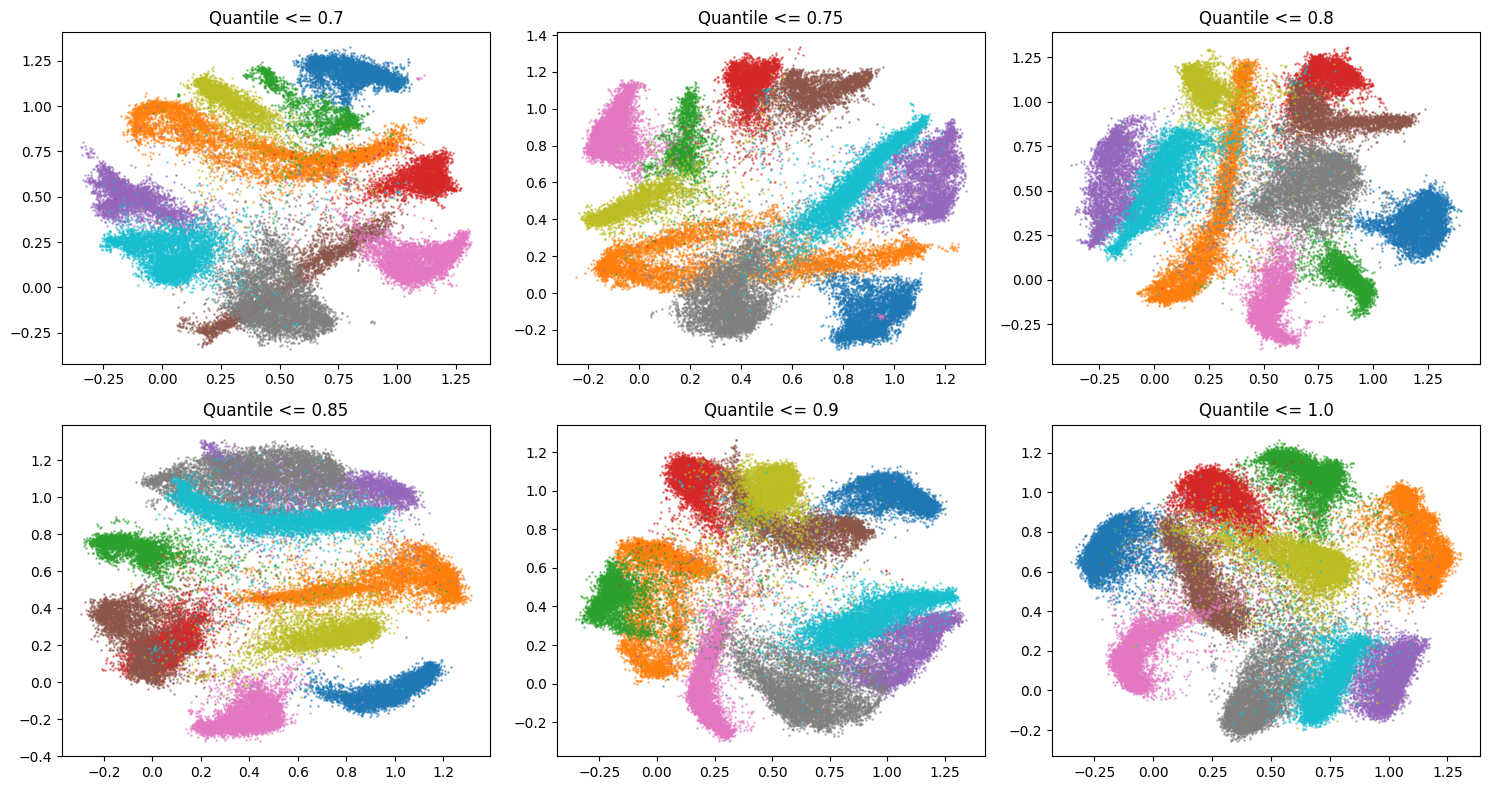

In [30]:
quantiles = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, quantile in enumerate(quantiles):
    threshold = np.quantile(mean_distances, quantile)
    indices_below = np.where(mean_distances < threshold)[0]

    X_below = X[indices_below]
    y_below = y[indices_below]
    graphs = create_graphs(X_below, metric="euclidean", nn=5)

    X_embedded = fit_fvhd_embedding(
        X_below, graphs, nn=5, rn=2, mutual_neighbors_epochs=None, verbose=False
    )


    unique_labels = np.unique(y_below)

    for j in unique_labels:
        points = X_embedded[y_below == j]
        axes[i].scatter(
            points[:, 0], points[:, 1], label=f"{j}", marker=".", s=3, alpha=0.5
        )

    axes[i].set_title(f"Quantile <= {quantile}")

plt.tight_layout()
plt.show()
